In [1]:
import pandas as pd
import numpy as np
!git clone https://github.com/ISorokos/SafeML.git

import sys
sys.path.insert(1, './SafeML/Implementation_in_Python')
from CVM_Distance import CVM_Dist as Cramer_Von_Mises_Dist
from Anderson_Darling_Distance import Anderson_Darling_Dist
from Kolmogorov_Smirnov_Distance import Kolmogorov_Smirnov_Dist
from KuiperDistance import Kuiper_Dist
from WassersteinDistance import Wasserstein_Dist
from DTS_Distance import DTS_Dist # Combo of Anderson_Darling and CVM distance.

fatal: destination path 'SafeML' already exists and is not an empty directory.


In [2]:
%matplotlib inline
import os, sys # For accessing Python Modules in the System Path (for accessing the Statistical Measures modules)
# See: https://stackoverflow.com/a/39311677
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import pandas as pd # For DataFrames, Series, and reading csv data in.
import seaborn as sns # Graphing, built ontop of MatPlot for ease-of-use and nicer diagrams.
import matplotlib.pyplot as plt # MatPlotLib for graphing data visually. Seaborn more likely to be used.
import numpy as np # For manipulating arrays and changing data into correct formats for certain libraries
import sklearn # For Machine Learning algorithms
import scikitplot # Confusion matrix plotting
from sklearn.decomposition import PCA # For PCA dimensionality reduction technique
from sklearn.preprocessing import StandardScaler # For scaling to unit scale, before PCA application
from sklearn.preprocessing import LabelBinarizer # For converting categorical data into numeric, for modeling stage
from sklearn.model_selection import StratifiedKFold # For optimal train_test splitting, for model input data
from sklearn.model_selection import train_test_split # For basic dataset splitting
from sklearn.neighbors import KNeighborsClassifier # K-Nearest Neighbors ML classifier (default n. of neighbors = 5)
from scikitplot.metrics import plot_confusion_matrix # For plotting confusion matrices
from sklearn.metrics import accuracy_score # For getting the accuracy of a model's predictions
from sklearn.metrics import classification_report # Various metrics for model performance
from sklearn.neural_network import MLPClassifier # For Neural Network classifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

Methods

In [3]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep]

In [4]:
def get_PCA_feature_names(num_of_pca_components):
    feature_names = []
    for i in range(num_of_pca_components):    
        feature_names.append(f"Principal component {i+1}")
    return feature_names

In [5]:
# See documentation above to understand what each step does, and why.
def train_model_predict(model, model_name, X, y, skf):
    for train_index, test_index in skf.split(X, y): # 1)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index] # 2)
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        reshaped_y_train = np.asarray(y_train).reshape(-1, 1) # 3)
        reshaped_y_test = np.asarray(y_test).reshape(-1, 1)
        
    model.fit(X_train, reshaped_y_train.ravel()) # 4)
    pred_y = model.predict(X_test) # 5)
    score = classification_report(reshaped_y_test, pred_y) # 6)
    print('Classification report: \n', score, '\n')
    plot_confusion_matrix(reshaped_y_test, pred_y, title='Confusion Matrix for {}'.format(model_name))
        
    return accuracy_score(reshaped_y_test, pred_y), X_train, X_test, y_train, pred_y

In [6]:
def get_shuffled_stratifiedKFold_train_test_split(X, y):
    # Shuffle to True, to get different shuffles each time. Permutations being varied is the goal here.
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    
    # For loop to get index for training and test data, using StratifiedKFold (3 splits)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # NOTE: Sometimes 'reshape' needed for label, so that the model can use it (required in SciKit)
        #reshaped_y_train = np.asarray(y_train).reshape(-1, 1)
        #reshaped_y_test = np.asarray(y_test).reshape(-1, 1)
        
    # After for loop ends, all training and test data has been retrieved thus can return it.
    return X_train, X_test, y_train, y_test

In [7]:
def train_and_predict_Neural_Network_MLP_model(X_train, X_test, y_train, y_test):
    # Instantiating new Neural Network classifier and setting Hyperparameters
    Neural_Net_model = MLPClassifier(hidden_layer_sizes=(10,), activation='relu',
                                    solver='adam', alpha=0.01, batch_size='auto',
                                    learning_rate='adaptive', learning_rate_init=0.1,
                                    max_iter=2)
    
    # Fitting the model is synonymous to training the model. Need to call .ravel() to get array in correct format.
    Neural_Net_model.fit(X_train, y_train.ravel())
    
    # Using the model to predict the label/ classes, based upon X_test data only. This is the model's answers.
    pred_y = Neural_Net_model.predict(X_test) 
    
    # Returning model answers and the accuracy of the model i.e. how well it predicts the answers.
    return pred_y, accuracy_score(y_test, pred_y)

In [8]:
import lightgbm as lgb

def train_and_predict_LGB(X_train, X_test, y_train, y_test):
    # Instantiating new Light GBM classifier and setting Hyperparameters
    lgb_params = {'n_estimators':1000,
                  'boosting_type': 'gbdt',
                  'objective': 'binary',
                  'metric': 'auc',
                 }
    #Defining the training dataset
    lgb_data = lgb.Dataset(X_train, y_train)
    
    #Training the Light GBM classifier
    bst = lgb.train(lgb_params, lgb_data)
    
    # Using the model to predict the label/ classes, based upon X_test data only. This is the model's answers.
    pred_y = bst.predict(X_test) 
    
    # Evaluate AUC Score
    from sklearn.metrics import roc_auc_score
    
    # Returning model answers and the accuracy of the model i.e. how well it predicts the answers.
    return pred_y, roc_auc_score(y_test, pred_y)

In [9]:
# send to top and add documentation
def get_statistical_dist_measures_for_class_result(accuracy, X_train_L, X_test_L):
    # Can use this to loop over all the features, since the ECDF Python methods are currently Univariate only
    num_of_features = len(X_train_L.columns)
    
    # Instantiate empty arrays with large enough size, to hold statistical distance data
    CVM_distances = np.zeros(num_of_features)
    Anderson_Darling_distances = np.zeros(num_of_features)
    Kolmogorov_Smirnov_distances = np.zeros(num_of_features)
    Kuiper_distances = np.zeros(num_of_features)
    Wasserstein_distances = np.zeros(num_of_features)
    DTS_distances = np.zeros(num_of_features)

    for i in range(0, num_of_features):
        # iloc[:, i] allows selection of the ith feature in the Pandas dataframe
        # Calling the methods from the imported Python modules (see import section at top of notebook)
        CVM_distances[i] = Cramer_Von_Mises_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        Anderson_Darling_distances[i] = Anderson_Darling_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        Kolmogorov_Smirnov_distances[i] = Kolmogorov_Smirnov_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        Kuiper_distances[i] = Kuiper_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        Wasserstein_distances[i] = Wasserstein_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        DTS_distances[i] = DTS_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
        
    # Computing mean/ average, to get ECDF distance of full dataset. Float64 to keep accuracy high.
    # See: https://numpy.org/doc/stable/reference/generated/numpy.mean.html
    CVM_distance = np.mean(CVM_distances, dtype=np.float64)
    Anderson_Darling_distance = np.mean(Anderson_Darling_distances, dtype=np.float64)
    Kolmogorov_Smirnov_distance = np.mean(Kolmogorov_Smirnov_distances, dtype=np.float64)
    Kuiper_distance = np.mean(Kuiper_distances, dtype=np.float64)
    Wasserstein_distance = np.mean(Wasserstein_distances, dtype=np.float64)
    DTS_distance = np.mean(DTS_distances, dtype=np.float64)
    
    # Returning dictionary, for efficient and fast DataFrame creation. Returns mean for each distance.
    # See https://stackoverflow.com/a/17496530. Fast way to 'append' to dataframe for results table.
    # PRESERVE THE ORDERING
    return {'Accuracy': accuracy,
            'Anderson_Darling_dist': Anderson_Darling_distance,
            'CVM_dist': CVM_distance,
            'DTS_dist':DTS_distance,
            'Kolmogorov_Smirnov_dist':Kolmogorov_Smirnov_distance,
            'Kuiper_dist': Kuiper_distance,
            'Wasserstein_dist': Wasserstein_distance}

In [10]:
def get_X_train_and_test_data_for_given_label(labels, label_index, pred_y, X_train, X_test, y_train, y_test):
    X_train_loc_for_label = X_train.loc[y_train == labels[label_index]]
    X_test_loc_for_label = X_test.loc[pred_y == labels[label_index]]
    
    return X_train_loc_for_label, X_test_loc_for_label

In [11]:
# Using f-strings: https://www.journaldev.com/23642/python-concatenate-string-and-int
def get_concatenated_results_holding_all_classes_results(number_of_classes, result_dataframes):
    # Empty list to dynamically hold the dataframes which have been assigned a new dataset column
    dataframes = []
    
    # For each class/ label
    for i in range(number_of_classes):
        class_name = f'class{i}'
        dataframes.append(result_dataframes[i].assign(dataset = class_name))
    
    concatenated = pd.concat(dataframes)
    
    return concatenated

Useful environment variables

In [12]:
# 'Reduced dimensions' variable for altering the number of PCA principal components. Can be altered for needs.
# Only 7 principal components needed when using non-normalised PCA dataset.
dimensions_num_for_PCA = 7

# Max number of permutations to run. Can be altered for needs.
number_of_permutations = 100

# 10 folds is usually the heuristic to follow for larger datasets of around this size.
num_of_splits_for_skf = 10

# Seed value to pass into models so that repeated runs result in the same output
seed_val = 1

# Number of statistical distance measures to run (for the results, columns section)
num_of_statistical_dist_measures = 6

Reading Dataset

In [13]:
PortScan = pd.read_csv(r'D:\โปรเจค\Data_set\MachineLearningCSV\MachineLearningCVE\PortScan.pcap_ISCX.csv')
df = PortScan.copy()
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


Preprocessing Dataset

In [14]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '') # ลบช่องว่างในชื่อคอลัมน์
df.head()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [15]:
df.dtypes

destination_port                 int64
flow_duration                    int64
total_fwd_packets                int64
total_backward_packets           int64
total_length_of_fwd_packets      int64
                                ...   
idle_mean                      float64
idle_std                       float64
idle_max                         int64
idle_min                         int64
label                           object
Length: 79, dtype: object

Fixing issues with ScikitLearn's PCA transform on this dataset

In [16]:
df_cleaned = df.copy()
df_cleaned = clean_dataset(df_cleaned.copy())
df_cleaned

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286462,443,196135,49,57,1331,105841,570,0,27.163265,108.067176,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286463,443,378424,49,59,1325,104393,570,0,27.040816,108.095051,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286464,443,161800,70,103,1427,215903,570,0,20.385714,90.746389,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286465,443,142864,50,62,1331,110185,570,0,26.620000,107.027727,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [17]:
df_cleaned = df_cleaned.reset_index()
# Removing un-needed index column added by reset_index method
df_cleaned.drop('index', axis=1, inplace=True)
df_cleaned

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286091,443,196135,49,57,1331,105841,570,0,27.163265,108.067176,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286092,443,378424,49,59,1325,104393,570,0,27.040816,108.095051,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286093,443,161800,70,103,1427,215903,570,0,20.385714,90.746389,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286094,443,142864,50,62,1331,110185,570,0,26.620000,107.027727,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [18]:
df.columns.tolist()

['destination_port',
 'flow_duration',
 'total_fwd_packets',
 'total_backward_packets',
 'total_length_of_fwd_packets',
 'total_length_of_bwd_packets',
 'fwd_packet_length_max',
 'fwd_packet_length_min',
 'fwd_packet_length_mean',
 'fwd_packet_length_std',
 'bwd_packet_length_max',
 'bwd_packet_length_min',
 'bwd_packet_length_mean',
 'bwd_packet_length_std',
 'flow_bytes/s',
 'flow_packets/s',
 'flow_iat_mean',
 'flow_iat_std',
 'flow_iat_max',
 'flow_iat_min',
 'fwd_iat_total',
 'fwd_iat_mean',
 'fwd_iat_std',
 'fwd_iat_max',
 'fwd_iat_min',
 'bwd_iat_total',
 'bwd_iat_mean',
 'bwd_iat_std',
 'bwd_iat_max',
 'bwd_iat_min',
 'fwd_psh_flags',
 'bwd_psh_flags',
 'fwd_urg_flags',
 'bwd_urg_flags',
 'fwd_header_length',
 'bwd_header_length',
 'fwd_packets/s',
 'bwd_packets/s',
 'min_packet_length',
 'max_packet_length',
 'packet_length_mean',
 'packet_length_std',
 'packet_length_variance',
 'fin_flag_count',
 'syn_flag_count',
 'rst_flag_count',
 'psh_flag_count',
 'ack_flag_count',
 'ur

Data Preparation: PCA Dimension reduction and scaling (Hughes' Phenomenon)

In [19]:
# Saving the label attribute before dropping it.
df_labels = df_cleaned['label']
# Shows all the possible labels/ classes a model can predict.
# Need to alter these to numeric 0, 1, etc... for model comprehension (e.g. pd.get_dummies()).
df_labels.unique()

array(['BENIGN', 'PortScan'], dtype=object)

In [20]:
# Axis=1 means columns. Axis=0 means rows. inplace=False means that the original 'df' isn't altered.
df_no_labels = df_cleaned.drop('label', axis=1, inplace=False)
# Getting feature names for the StandardScaler process
df_features = df_no_labels.columns.tolist()
# Printing out Dataframe with no label column, to show successful dropping
df_no_labels

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286091,443,196135,49,57,1331,105841,570,0,27.163265,108.067176,...,31,20,0.0,0.0,0,0,0.0,0.0,0,0
286092,443,378424,49,59,1325,104393,570,0,27.040816,108.095051,...,30,20,0.0,0.0,0,0,0.0,0.0,0,0
286093,443,161800,70,103,1427,215903,570,0,20.385714,90.746389,...,47,20,0.0,0.0,0,0,0.0,0.0,0,0
286094,443,142864,50,62,1331,110185,570,0,26.620000,107.027727,...,31,20,0.0,0.0,0,0,0.0,0.0,0,0


Using StandardScaler to transform features into unit scale (optional for PCA)

In [21]:
df_scaled = StandardScaler().fit_transform(df_no_labels)
# Converting back to dataframe
df_scaled = pd.DataFrame(data = df_scaled, columns = df_features)
df_scaled

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,-0.520898,-0.187809,1.921576,1.429893,1.301913,0.083183,1.143000,-0.427193,0.520360,0.726763,...,1.493893,0.364318,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
1,-0.520898,-0.185393,1.921576,1.429893,1.301913,0.083183,1.143000,-0.427193,0.520360,0.726763,...,1.493893,0.364318,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
2,-0.520898,-0.245528,-0.126811,-0.089163,-0.125195,-0.053141,-0.247378,-0.427193,-0.308105,-0.209924,...,-0.116102,0.364318,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
3,-0.520898,-0.186116,1.921576,1.359240,1.336198,0.076910,1.143000,-0.427193,0.540263,0.729026,...,1.493893,0.364318,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
4,1.784164,-0.245532,-0.126811,-0.053837,-0.125195,-0.053141,-0.247378,-0.427193,-0.308105,-0.209924,...,-0.116102,0.364318,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286091,-0.493464,-0.236595,2.331253,1.889143,0.587823,2.021738,1.490594,-0.427193,0.038237,0.711439,...,1.963476,-1.133141,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
286092,-0.493464,-0.228285,2.331253,1.959797,0.584609,1.993352,1.490594,-0.427193,0.036676,0.711676,...,1.896392,-1.133141,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
286093,-0.493464,-0.238160,3.406657,3.514181,0.639251,4.179364,1.490594,-0.427193,-0.048179,0.563765,...,3.036806,-1.133141,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
286094,-0.493464,-0.239023,2.382463,2.065778,0.587823,2.106896,1.490594,-0.427193,0.031310,0.702577,...,1.963476,-1.133141,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561


Plotting principle component variance

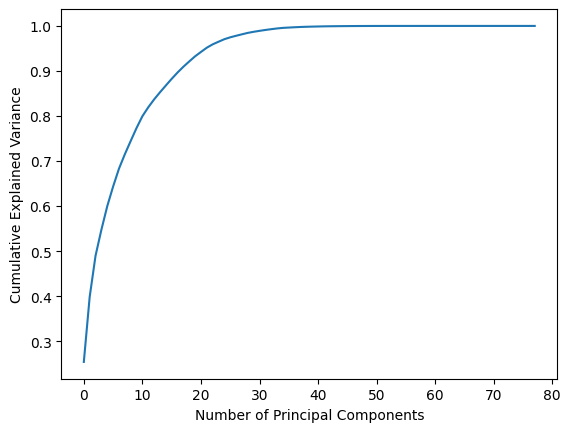

In [22]:
pca_test = PCA().fit(df_scaled)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

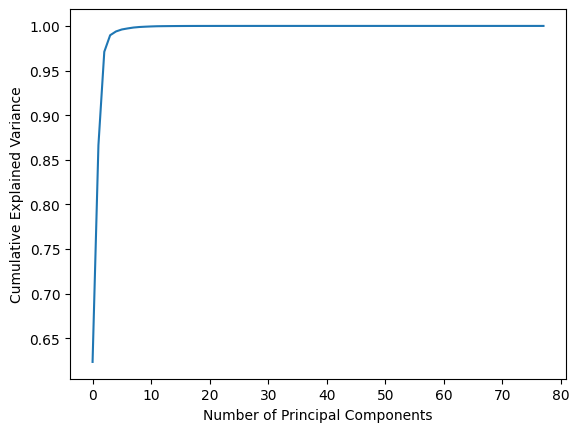

In [23]:
# The df_no_labels dataset holds the un-normalised dataset.
pca_test = PCA().fit(df_no_labels)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

Now fitting and transforming the data with PCA

In [24]:
pca = PCA(n_components=dimensions_num_for_PCA)
#principal_components = pca.fit(df_scaled).transform(df_scaled) => for normalised PCA

# Non-normalised PCA
principal_components = pca.fit(df_no_labels).transform(df_no_labels)
principal_components

array([[-8.16580279e+06, -1.19915322e+06,  1.27263308e+05, ...,
         8.93600581e+05,  2.96811663e+05,  5.98234594e+03],
       [-8.08590567e+06, -1.19861324e+06,  9.21736216e+04, ...,
         8.99819189e+05,  2.96878115e+05,  5.81150453e+03],
       [-1.00194924e+07, -1.22629216e+06,  2.02487220e+05, ...,
        -2.15507753e+05, -5.82407941e+04, -3.75222176e+04],
       ...,
       [-9.77881129e+06,  1.20711384e+05,  1.08402286e+05, ...,
        -1.99889067e+05, -4.93926336e+04, -4.26804840e+04],
       [-9.80388112e+06, -4.42548507e+05,  1.21580327e+05, ...,
        -1.96639141e+05, -4.85337246e+04, -3.96503044e+04],
       [-9.72175186e+06, -6.79955648e+05,  1.08244069e+05, ...,
        -1.93449359e+05, -3.30418761e+04, -3.68706087e+04]])

Getting Principal Component feature names, dynamically

In [25]:
# See Methods at the top of the notebook
principal_component_headings = get_PCA_feature_names(dimensions_num_for_PCA)

In [26]:
df_pc = pd.DataFrame(data = principal_components, columns = principal_component_headings)
df_pc

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7
0,-8.165803e+06,-1.199153e+06,127263.307756,231525.444244,893600.580534,296811.662984,5982.345935
1,-8.085906e+06,-1.198613e+06,92173.621578,222554.882115,899819.189254,296878.115459,5811.504529
2,-1.001949e+07,-1.226292e+06,202487.219507,-114026.034526,-215507.753418,-58240.794133,-37522.217603
3,-8.104574e+06,-1.198907e+06,114579.819424,232052.538819,886792.249240,309302.450961,6391.775131
4,-1.001953e+07,-1.226232e+06,202496.514118,-114079.976276,-215668.219754,-58255.708667,-37616.209415
...,...,...,...,...,...,...,...
286091,-9.702691e+06,-6.754558e+05,108811.962532,-113698.699726,-192210.876425,-27627.809010,-36484.272722
286092,-9.338204e+06,-9.387585e+05,107612.275294,-53678.418683,-166703.000669,86349.888528,-14930.171400
286093,-9.778811e+06,1.207114e+05,108402.286219,-123110.822316,-199889.066997,-49392.633591,-42680.484006
286094,-9.803881e+06,-4.425485e+05,121580.327254,-122251.188352,-196639.141355,-48533.724648,-39650.304436


Joining/ concatinating the label feature back onto the pca transformed dataset

In [27]:
df_final = pd.concat([df_pc, df_labels], axis = 1)
# Scroll to the RHS end of dataframe to see attached label feature
df_final

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7,label
0,-8.165803e+06,-1.199153e+06,127263.307756,231525.444244,893600.580534,296811.662984,5982.345935,BENIGN
1,-8.085906e+06,-1.198613e+06,92173.621578,222554.882115,899819.189254,296878.115459,5811.504529,BENIGN
2,-1.001949e+07,-1.226292e+06,202487.219507,-114026.034526,-215507.753418,-58240.794133,-37522.217603,BENIGN
3,-8.104574e+06,-1.198907e+06,114579.819424,232052.538819,886792.249240,309302.450961,6391.775131,BENIGN
4,-1.001953e+07,-1.226232e+06,202496.514118,-114079.976276,-215668.219754,-58255.708667,-37616.209415,BENIGN
...,...,...,...,...,...,...,...,...
286091,-9.702691e+06,-6.754558e+05,108811.962532,-113698.699726,-192210.876425,-27627.809010,-36484.272722,BENIGN
286092,-9.338204e+06,-9.387585e+05,107612.275294,-53678.418683,-166703.000669,86349.888528,-14930.171400,BENIGN
286093,-9.778811e+06,1.207114e+05,108402.286219,-123110.822316,-199889.066997,-49392.633591,-42680.484006,BENIGN
286094,-9.803881e+06,-4.425485e+05,121580.327254,-122251.188352,-196639.141355,-48533.724648,-39650.304436,BENIGN


Transforming the label feature's categorical data into numeric data (via LabelBinarizer)

In [28]:
lb = LabelBinarizer()
df_final['label'] = lb.fit_transform(df_final['label'])
df_final

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7,label
0,-8.165803e+06,-1.199153e+06,127263.307756,231525.444244,893600.580534,296811.662984,5982.345935,0
1,-8.085906e+06,-1.198613e+06,92173.621578,222554.882115,899819.189254,296878.115459,5811.504529,0
2,-1.001949e+07,-1.226292e+06,202487.219507,-114026.034526,-215507.753418,-58240.794133,-37522.217603,0
3,-8.104574e+06,-1.198907e+06,114579.819424,232052.538819,886792.249240,309302.450961,6391.775131,0
4,-1.001953e+07,-1.226232e+06,202496.514118,-114079.976276,-215668.219754,-58255.708667,-37616.209415,0
...,...,...,...,...,...,...,...,...
286091,-9.702691e+06,-6.754558e+05,108811.962532,-113698.699726,-192210.876425,-27627.809010,-36484.272722,0
286092,-9.338204e+06,-9.387585e+05,107612.275294,-53678.418683,-166703.000669,86349.888528,-14930.171400,0
286093,-9.778811e+06,1.207114e+05,108402.286219,-123110.822316,-199889.066997,-49392.633591,-42680.484006,0
286094,-9.803881e+06,-4.425485e+05,121580.327254,-122251.188352,-196639.141355,-48533.724648,-39650.304436,0


In [29]:
print("Before LabelBinarizer: ", df_labels.unique())
print("After LabelBinarizer: ", df_final['label'].unique())

Before LabelBinarizer:  ['BENIGN' 'PortScan']
After LabelBinarizer:  [0 1]


Train and Validation

K-Fold Cross Validation and Stratified splitting

In [30]:
# Separating the label so that the answers aren't provided to the model, in training.
X = df_final.drop(['label'], axis = 1)
y = df_final['label']
y

0         0
1         0
2         0
3         0
4         0
         ..
286091    0
286092    0
286093    0
286094    0
286095    0
Name: label, Length: 286096, dtype: int32

In [31]:
skf = StratifiedKFold(n_splits=num_of_splits_for_skf, shuffle=False)
skf

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [32]:
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    reshaped_y_train = np.asarray(y_train).reshape(-1, 1)
    reshaped_y_test = np.asarray(y_test).reshape(-1, 1)
    
print( 'X_train length: ', len(X_train) ) # To check if splits worked
print( 'y_train length: ', len(y_train) )
print( 'X_test length: ', len(X_test) )
print( 'y_test length: ', len(y_test) )

X_train length:  257487
y_train length:  257487
X_test length:  28609
y_test length:  28609


Modelling Stage

K-Nearest neighbor ML classifier

In [33]:
knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform',
                                    algorithm='auto', leaf_size=30,
                                    p=2, metric='minkowski',
                                    metric_params=None, n_jobs=None)

Training the model and predicting test data results (confusion matrix)

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12729
           1       1.00      1.00      1.00     15880

    accuracy                           1.00     28609
   macro avg       1.00      1.00      1.00     28609
weighted avg       1.00      1.00      1.00     28609
 

Model accuracy=  99.65395504911042 %

Dataset labels:  ['BENIGN' 'PortScan']
Dataset numeric labels after encoding for model:  [0 1]


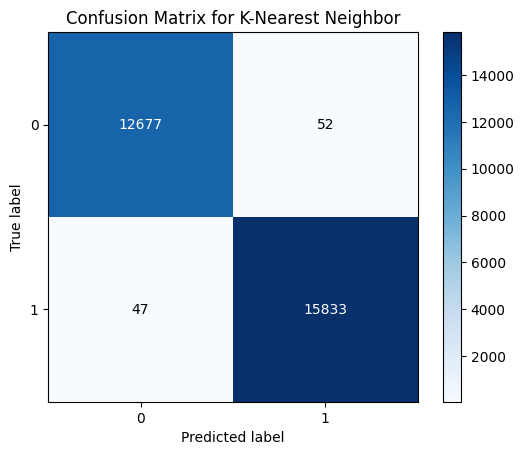

In [34]:
# Unpacking the method return values. Last 4 are needed for statistical distance measure methods.
accuracy, X_train, X_test, y_train, pred_y = train_model_predict(knn_model, "K-Nearest Neighbor", X, y, skf)
print("Model accuracy= ", accuracy*100, "%\n")
print("Dataset labels: ", df_labels.unique())
print("Dataset numeric labels after encoding for model: ", df_final['label'].unique())

SafeML

The SafeML statistical distance measures: test/ example run

In [35]:
# Extracting the number of classes and labels from the label feature
class_num = len(df_final['label'].unique())
labels = df_final['label'].unique()
print("Number of classes: ", class_num)
print("Labels: ", labels)

Number of classes:  2
Labels:  [0 1]


In [36]:
X_train

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7
0,-8.165803e+06,-1.199153e+06,1.272633e+05,2.315254e+05,893600.580534,2.968117e+05,5.982346e+03
1,-8.085906e+06,-1.198613e+06,9.217362e+04,2.225549e+05,899819.189254,2.968781e+05,5.811505e+03
2,-1.001949e+07,-1.226292e+06,2.024872e+05,-1.140260e+05,-215507.753418,-5.824079e+04,-3.752222e+04
3,-8.104574e+06,-1.198907e+06,1.145798e+05,2.320525e+05,886792.249240,3.093025e+05,6.391775e+03
4,-1.001953e+07,-1.226232e+06,2.024965e+05,-1.140800e+05,-215668.219754,-5.825571e+04,-3.761621e+04
...,...,...,...,...,...,...,...
264345,2.198678e+08,1.380216e+06,1.701027e+08,-5.037324e+07,351189.985289,-3.080752e+06,2.176100e+06
264346,-9.906154e+06,-1.223417e+06,2.222463e+05,-1.001826e+05,-118844.252902,-2.512903e+04,-1.045444e+02
264347,-9.974813e+06,-1.223502e+06,2.102830e+05,-1.085742e+05,-177375.336509,-4.516016e+04,-2.274868e+04
264348,-9.991084e+06,-1.218311e+06,2.086187e+05,-1.100024e+05,-191929.370539,-4.893430e+04,-3.011515e+04


In [37]:
# x1 = X_test[np.where(np.asarray(y_train).reshape(-1, 1).ravel() == labels[0])]
# X_train_L = X_train.iloc[np.where(y_train[:,1] == 1)]
X_train_L = X_train.loc[y_train == labels[0]]
X_train_L

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7
0,-8.165803e+06,-1.199153e+06,1.272633e+05,2.315254e+05,893600.580534,2.968117e+05,5.982346e+03
1,-8.085906e+06,-1.198613e+06,9.217362e+04,2.225549e+05,899819.189254,2.968781e+05,5.811505e+03
2,-1.001949e+07,-1.226292e+06,2.024872e+05,-1.140260e+05,-215507.753418,-5.824079e+04,-3.752222e+04
3,-8.104574e+06,-1.198907e+06,1.145798e+05,2.320525e+05,886792.249240,3.093025e+05,6.391775e+03
4,-1.001953e+07,-1.226232e+06,2.024965e+05,-1.140800e+05,-215668.219754,-5.825571e+04,-3.761621e+04
...,...,...,...,...,...,...,...
264345,2.198678e+08,1.380216e+06,1.701027e+08,-5.037324e+07,351189.985289,-3.080752e+06,2.176100e+06
264346,-9.906154e+06,-1.223417e+06,2.222463e+05,-1.001826e+05,-118844.252902,-2.512903e+04,-1.045444e+02
264347,-9.974813e+06,-1.223502e+06,2.102830e+05,-1.085742e+05,-177375.336509,-4.516016e+04,-2.274868e+04
264348,-9.991084e+06,-1.218311e+06,2.086187e+05,-1.100024e+05,-191929.370539,-4.893430e+04,-3.011515e+04


In [38]:
X_test_L = X_test.loc[pred_y == labels[0]]
X_test_L

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7
247042,-1.003719e+07,3.746366e+05,201535.291293,-113791.182822,-215671.736504,-58453.724072,-37876.926666
247162,-9.474344e+06,-1.171362e+06,290499.044682,-24916.077897,-159436.069748,202752.848791,89131.592084
247164,-1.007432e+07,4.610053e+06,193101.984439,-101728.148800,-209863.707542,-74877.503832,-47190.555650
248237,-9.271826e+06,-1.181135e+06,323589.702362,8387.451593,-138267.409296,300314.086017,136380.325307
248241,-1.007971e+07,4.969413e+06,194145.860996,-104411.735824,-210512.019112,-70642.129348,-44726.982493
...,...,...,...,...,...,...,...
286091,-9.702691e+06,-6.754558e+05,108811.962532,-113698.699726,-192210.876425,-27627.809010,-36484.272722
286092,-9.338204e+06,-9.387585e+05,107612.275294,-53678.418683,-166703.000669,86349.888528,-14930.171400
286093,-9.778811e+06,1.207114e+05,108402.286219,-123110.822316,-199889.066997,-49392.633591,-42680.484006
286094,-9.803881e+06,-4.425485e+05,121580.327254,-122251.188352,-196639.141355,-48533.724648,-39650.304436


Running the Statistical distance measure algorithms

In [39]:
num_of_features = len(X_train_L.columns)
num_of_features

7

In [40]:
CVM_distances = np.zeros(num_of_features)
Anderson_Darling_distances = np.zeros(num_of_features)
Kolmogorov_Smirnov_distances = np.zeros(num_of_features)
Kuiper_distances = np.zeros(num_of_features)
Wasserstein_distances = np.zeros(num_of_features)
DTS_distances = np.zeros(num_of_features)

for i in range(0, num_of_features):
    # iloc[:, i] allows selection of the ith feature in the Pandas dataframe 
    CVM_distances[i] = Cramer_Von_Mises_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    Anderson_Darling_distances[i] = Anderson_Darling_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    Kolmogorov_Smirnov_distances[i] = Kolmogorov_Smirnov_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    Kuiper_distances[i] = Kuiper_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    Wasserstein_distances[i] = Wasserstein_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    DTS_distances[i] = DTS_Dist(X_train_L.iloc[:, i], X_test_L.iloc[:, i])
    
print(" Cramer Von Mises distances: ", CVM_distances)
print("\n Anderson Darling distances: ", Anderson_Darling_distances)
print("\n Kolmogorov Smirnov distances: ", Kolmogorov_Smirnov_distances)
print("\n Kuiper distances: ", Kuiper_distances)
print("\n Wasserstein distances: ", Wasserstein_distances)
print("\n DTS distances: ", DTS_distances)

 Cramer Von Mises distances:  [2145.09062898 3554.18538115 2795.2436322  1583.62379235 1961.45443754
 4157.49306459 3448.61466525]

 Anderson Darling distances:  [15.67865018 23.73500686 18.74131197 11.34771928 12.67932826 26.91382278
 22.30160905]

 Kolmogorov Smirnov distances:  [0.03326813 0.06777357 0.04982426 0.03216095 0.03921818 0.06471298
 0.06118417]

 Kuiper distances:  [0.06600481 0.08118545 0.06521067 0.04751724 0.05236605 0.06570585
 0.06866847]

 Wasserstein distances:  [3632561.56936989  697564.99629972 1409309.94123757  503034.05463809
  196335.98494874  142255.88702355  100757.23898965]

 DTS distances:  [39541.56024532 41304.46940677 28045.40926569 12410.22839265
 10182.44208158  8299.55955336  8538.95643399]


Plotting the test/ example results

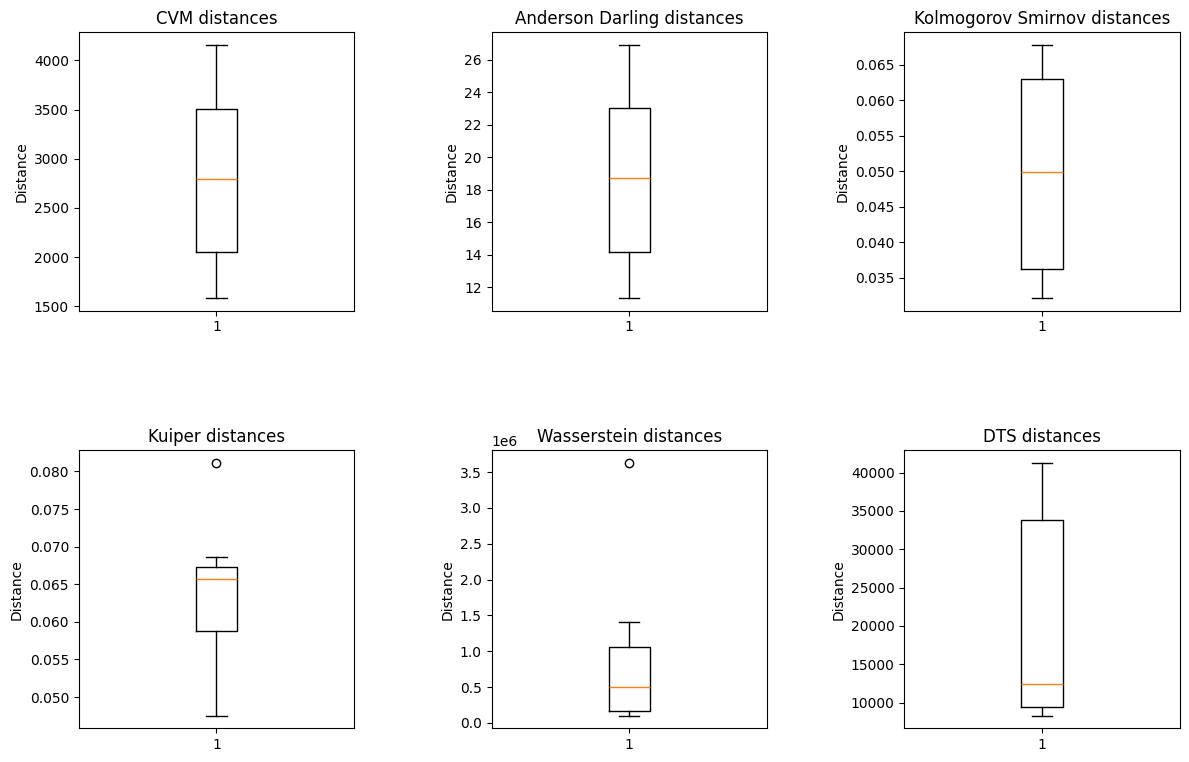

In [41]:
fig, axs = plt.subplots(2, 3)

axs[0, 0].boxplot(CVM_distances)
axs[0, 0].set_title('CVM distances')
axs[0, 0].set_ylabel("Distance")

axs[0, 1].boxplot(Anderson_Darling_distances)
axs[0, 1].set_title('Anderson Darling distances')
axs[0, 1].set_ylabel("Distance")

axs[0, 2].boxplot(Kolmogorov_Smirnov_distances)
axs[0, 2].set_title('Kolmogorov Smirnov distances')
axs[0, 2].set_ylabel("Distance")

axs[1, 0].boxplot(Kuiper_distances)
axs[1, 0].set_title("Kuiper distances")
axs[1, 0].set_ylabel("Distance")

axs[1, 1].boxplot(Wasserstein_distances)
axs[1, 1].set_title("Wasserstein distances")
axs[1, 1].set_ylabel("Distance")

axs[1, 2].boxplot(DTS_distances)
axs[1, 2].set_title("DTS distances")
axs[1, 2].set_ylabel("Distance")

fig.subplots_adjust(left=0.08, right=1.8, bottom=0.05, top=1.5, hspace=0.5, wspace=0.5)

plt.show()

Starting the real run, using the PCA-transformed dataset

In [42]:
df_final

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7,label
0,-8.165803e+06,-1.199153e+06,127263.307756,231525.444244,893600.580534,296811.662984,5982.345935,0
1,-8.085906e+06,-1.198613e+06,92173.621578,222554.882115,899819.189254,296878.115459,5811.504529,0
2,-1.001949e+07,-1.226292e+06,202487.219507,-114026.034526,-215507.753418,-58240.794133,-37522.217603,0
3,-8.104574e+06,-1.198907e+06,114579.819424,232052.538819,886792.249240,309302.450961,6391.775131,0
4,-1.001953e+07,-1.226232e+06,202496.514118,-114079.976276,-215668.219754,-58255.708667,-37616.209415,0
...,...,...,...,...,...,...,...,...
286091,-9.702691e+06,-6.754558e+05,108811.962532,-113698.699726,-192210.876425,-27627.809010,-36484.272722,0
286092,-9.338204e+06,-9.387585e+05,107612.275294,-53678.418683,-166703.000669,86349.888528,-14930.171400,0
286093,-9.778811e+06,1.207114e+05,108402.286219,-123110.822316,-199889.066997,-49392.633591,-42680.484006,0
286094,-9.803881e+06,-4.425485e+05,121580.327254,-122251.188352,-196639.141355,-48533.724648,-39650.304436,0


Starting the main loop and all other required loops (for permutations)

In [43]:
# Firstly, creating the final 2D-array (Pandas Dataframe) which will be used to store the Results
# PRESERVE THE ORDERING
results_column_names = ['Accuracy', 'Anderson_Darling_dist', 'CVM_dist',
                                     'DTS_dist', 'Kolmogorov_Smirnov_dist','Kuiper_dist', 'Wasserstein_dist']
# Creating the empty Dataframe for Results
df_results = pd.DataFrame(columns = results_column_names)
# Can copy this dataframe for future results tables e.g. for each class/ label
df_results

,Accuracy,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist


Code for each permutation

In [44]:
number_of_permutations = 100

In [45]:
from tqdm import tqdm

from sklearn.model_selection import train_test_split
# 1st Set all variables needed outside for loop scope, e.g. the multi-dimensional Results array.
labels = df_final['label'].unique()
number_of_classes = len(df_final['label'].unique())

# List of Lists to hold each separate label result, using list_index->label_number mapping (for accessing)
list_of_lists_results = [[] for i in range(number_of_classes)]

for current_permutation in tqdm(range(number_of_permutations)):
    # 1.1. Cross validation, train test stratified splitting (extracted to a function, see top of file)
    #koo #X_train, X_test, y_train, y_test = get_shuffled_stratifiedKFold_train_test_split(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=114)
    
    # 1.2. Train MLP (Neural net) model using the train test data, and model.predict to get pred_y
    pred_y, accuracy = train_and_predict_Neural_Network_MLP_model(X_train, X_test, y_train, y_test)
    #koo #pred_y, accuracy = train_and_predict_LGB(X_train, X_test, y_train, y_test)
    
    # 1.3. loop over each label/ class
    for current_label in range(number_of_classes):
        
        # 1.4. Gets the correct indices for the train and test data ('X' data holds no labels)
        X_train_loc_for_label, X_test_loc_for_label = get_X_train_and_test_data_for_given_label(labels,
                                                        current_label, pred_y, X_train, X_test, y_train, y_test)
        
        # 1.5. Gets all ECDF statistical distance measures for current_label
        dict_result_row = get_statistical_dist_measures_for_class_result(accuracy,
                                                X_train_loc_for_label, X_test_loc_for_label)
        
        # 1.6. Append new dict row to current_label index of list of lists
        list_of_lists_results[current_label].append(dict_result_row)

100%|██████████| 100/100 [12:01<00:00,  7.21s/it]


In [46]:
# Access specific dataframe by index e.g. class 1 dataframe->index 1 mapping
result_dataframes = []

for dict_result_list in list_of_lists_results:
    result_dataframes.append(pd.DataFrame(dict_result_list, columns = results_column_names))

In [47]:
# Print first dataframe result table, for class 0
result_dataframes[0].head()

,Accuracy,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0.623840,158.818934,18541.586421,363740.642145,0.464762,0.641189,2.226870e+07
1,0.645734,143.963528,17102.333365,258611.275822,0.396843,0.594559,1.586175e+07
2,0.632981,153.492866,18090.528820,326389.686042,0.428667,0.602675,1.982348e+07
3,0.642270,152.581255,18020.059352,288423.933585,0.415324,0.628503,1.772746e+07
4,0.650532,156.218233,18498.453315,309138.780675,0.408912,0.631167,1.875161e+07


In [48]:
result_dataframes[0].to_excel("Class0.xlsx")

In [49]:
# Print second dataframe result table, for class 1
result_dataframes[1].head(8)


,Accuracy,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0.623840,106.544262,17171.219968,21670.232145,0.287104,0.345245,534097.549561
1,0.645734,101.914989,16228.025892,19358.772554,0.275746,0.330524,454829.626303
2,0.632981,104.890903,16828.493525,18296.170718,0.282665,0.339848,471454.692042
3,0.642270,103.743048,16590.778514,17721.785547,0.279335,0.335393,423710.229666
4,0.650532,101.991123,16260.249181,6378.458046,0.275078,0.328902,103173.885714
5,0.640469,104.200525,16688.770191,18831.312748,0.280254,0.335866,441378.262375
6,0.654906,100.364238,15885.438989,17060.413239,0.270396,0.328067,387034.747815
7,0.661367,98.949965,15621.586788,17191.073632,0.267252,0.322742,383874.602067


In [50]:
result_dataframes[1].to_excel("Class1.xlsx")

Plotting the SafeML Results

In [51]:
concatenated = get_concatenated_results_holding_all_classes_results(number_of_classes, result_dataframes)
concatenated.head(110)

,Accuracy,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist,dataset
0,0.623840,158.818934,18541.586421,363740.642145,0.464762,0.641189,2.226870e+07,class0
1,0.645734,143.963528,17102.333365,258611.275822,0.396843,0.594559,1.586175e+07,class0
2,0.632981,153.492866,18090.528820,326389.686042,0.428667,0.602675,1.982348e+07,class0
3,0.642270,152.581255,18020.059352,288423.933585,0.415324,0.628503,1.772746e+07,class0
4,0.650532,156.218233,18498.453315,309138.780675,0.408912,0.631167,1.875161e+07,class0
...,...,...,...,...,...,...,...,...
5,0.640469,104.200525,16688.770191,18831.312748,0.280254,0.335866,4.413783e+05,class1
6,0.654906,100.364238,15885.438989,17060.413239,0.270396,0.328067,3.870347e+05,class1
7,0.661367,98.949965,15621.586788,17191.073632,0.267252,0.322742,3.838746e+05,class1
8,0.655097,100.359705,15899.706780,17307.369399,0.271024,0.326945,3.871937e+05,class1


Seaborn plotting

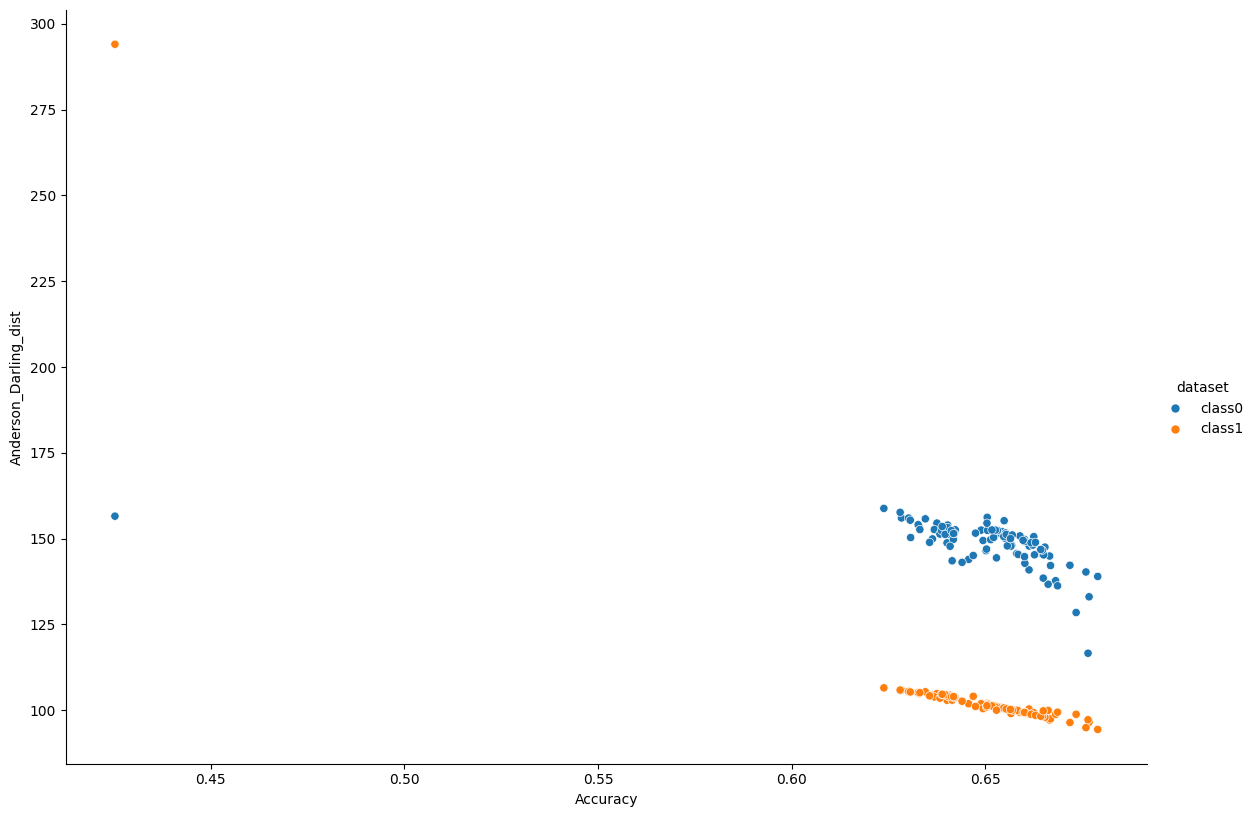

In [52]:
sns.relplot(data=concatenated, x='Accuracy', y='Anderson_Darling_dist',
                hue='dataset', height=8.27, aspect=11.7/8.27)

Seaborn pairplot

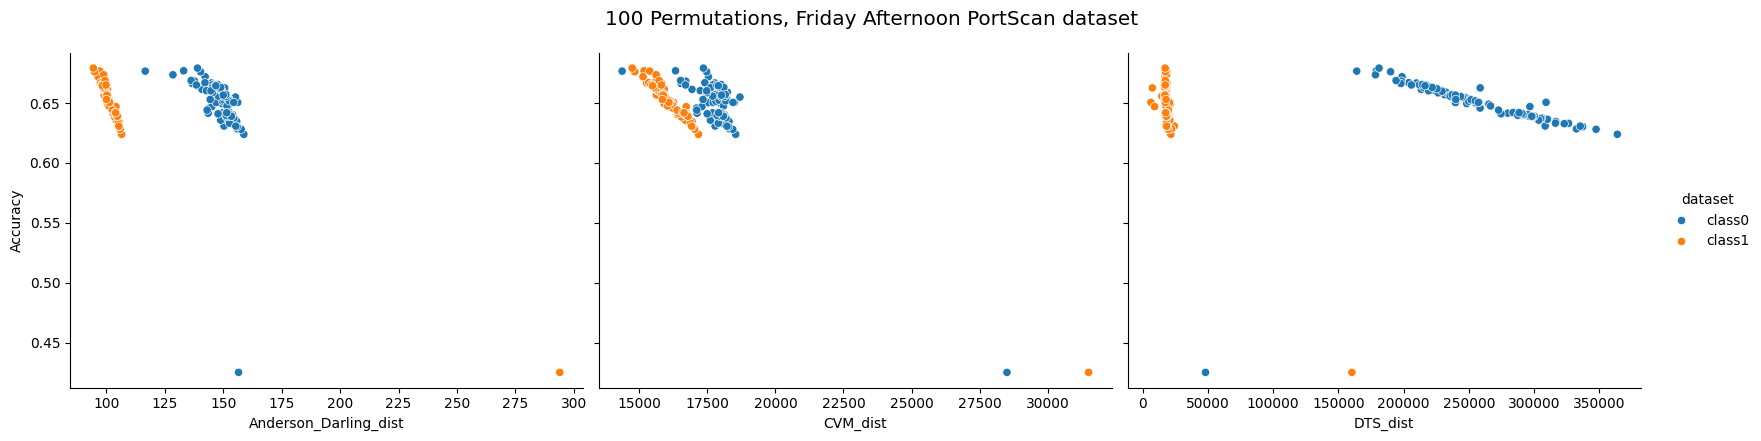

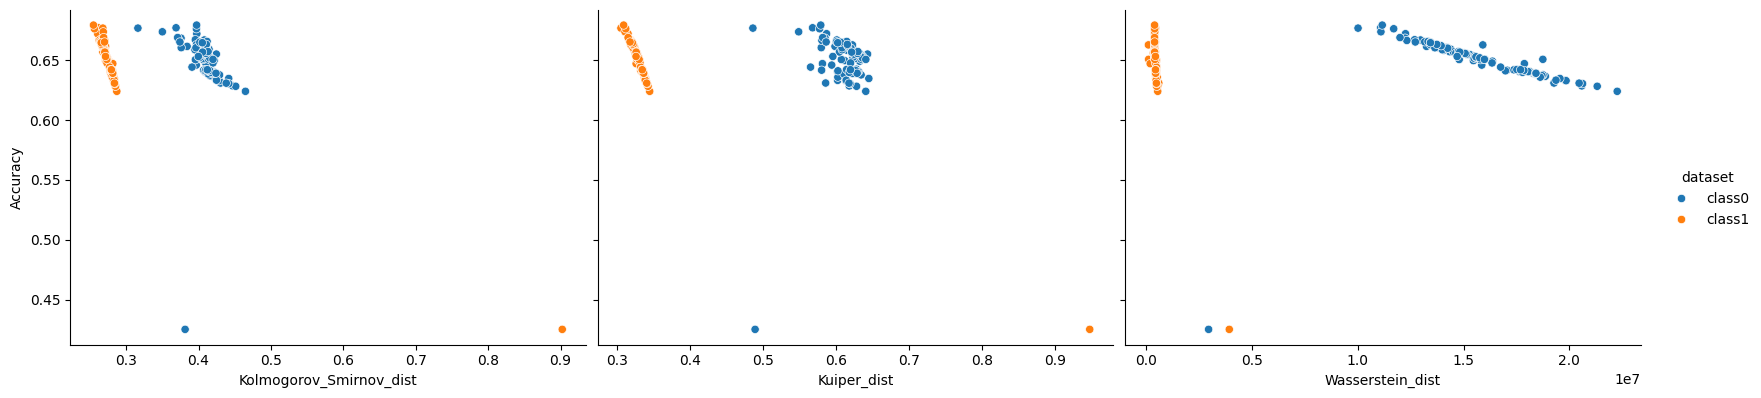

In [53]:
plot_title = "100 Permutations, Friday Afternoon PortScan dataset"

g = sns.pairplot(
    data=concatenated,
    y_vars=['Accuracy'],
    x_vars=['Anderson_Darling_dist', 'CVM_dist','DTS_dist'],
    hue='dataset',
    height=4,
    aspect=1.4
)
g.fig.suptitle(plot_title, y=1.08, fontsize='x-large')

sns.pairplot(
    data=concatenated,
    y_vars=['Accuracy'],
    x_vars=['Kolmogorov_Smirnov_dist','Kuiper_dist', 'Wasserstein_dist'],
    hue='dataset',
    height=4,
    aspect=1.4
)

Seaborn lineplot¶

<Axes: xlabel='Accuracy', ylabel='Anderson_Darling_dist'>

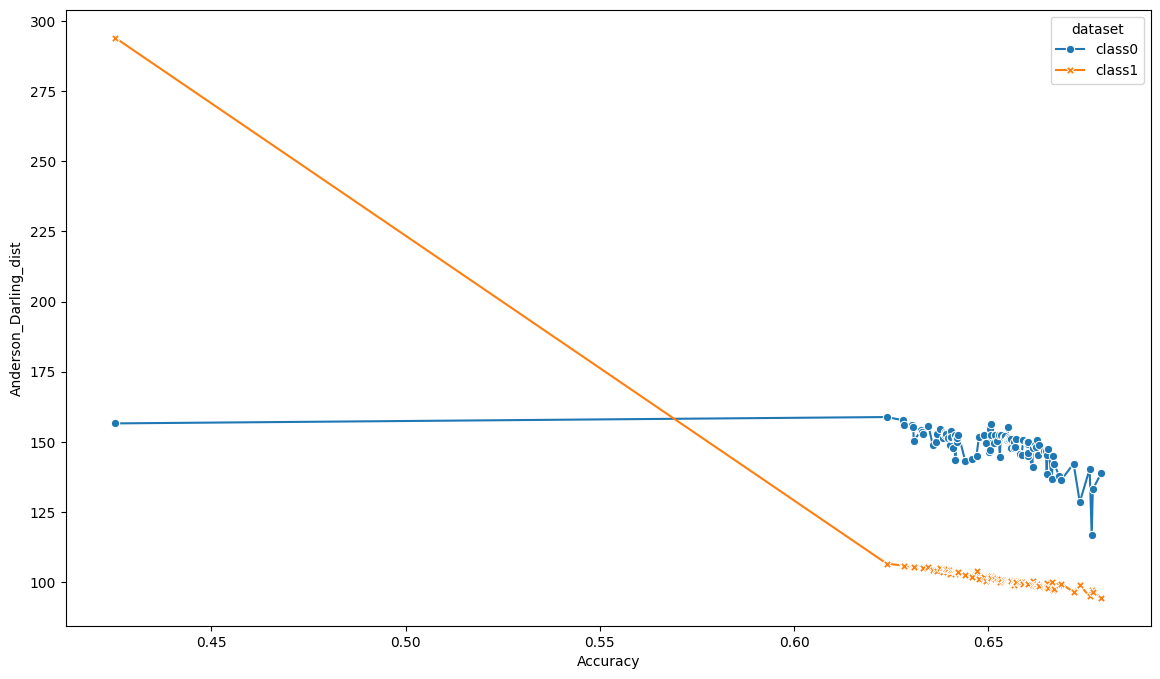

In [54]:
plt.figure(figsize=(14,8))
sns.lineplot(data=concatenated, x='Accuracy', y='Anderson_Darling_dist', hue="dataset", style="dataset",
    markers=True, dashes=False, err_style="bars", ci=40, estimator="mean")

<Axes: xlabel='Accuracy', ylabel='CVM_dist'>

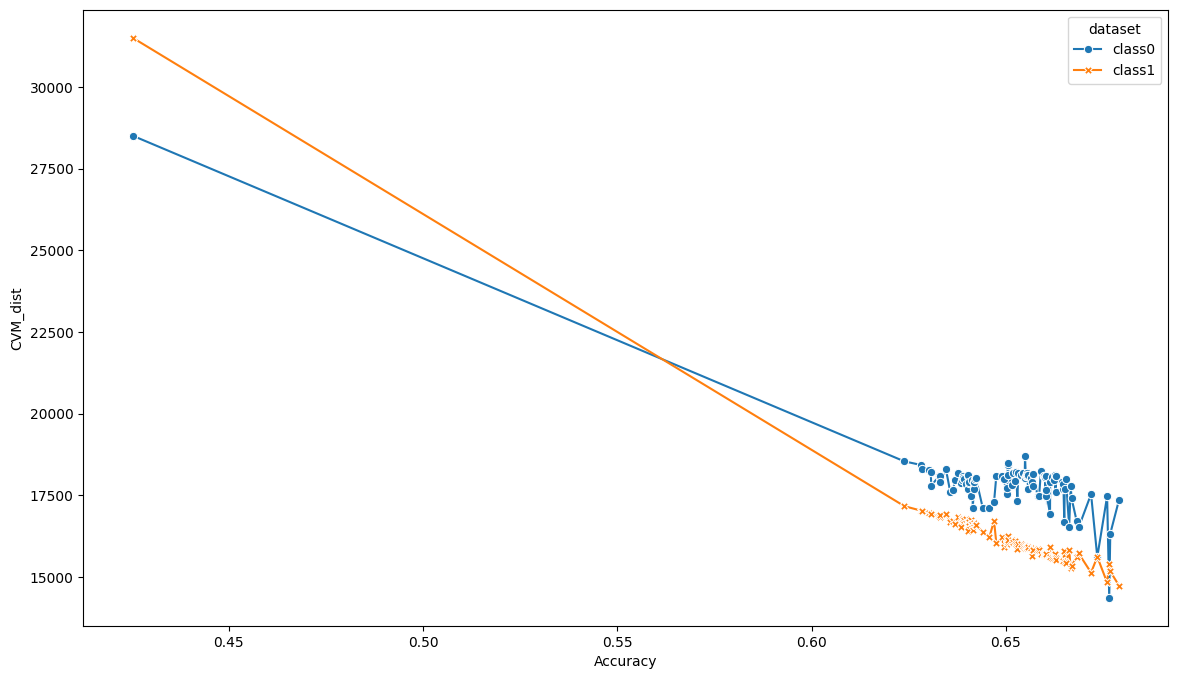

In [55]:
plt.figure(figsize=(14,8))
sns.lineplot(data=concatenated, x='Accuracy', y='CVM_dist', hue="dataset", style="dataset",
    markers=True, dashes=False)

<Axes: xlabel='Accuracy', ylabel='DTS_dist'>

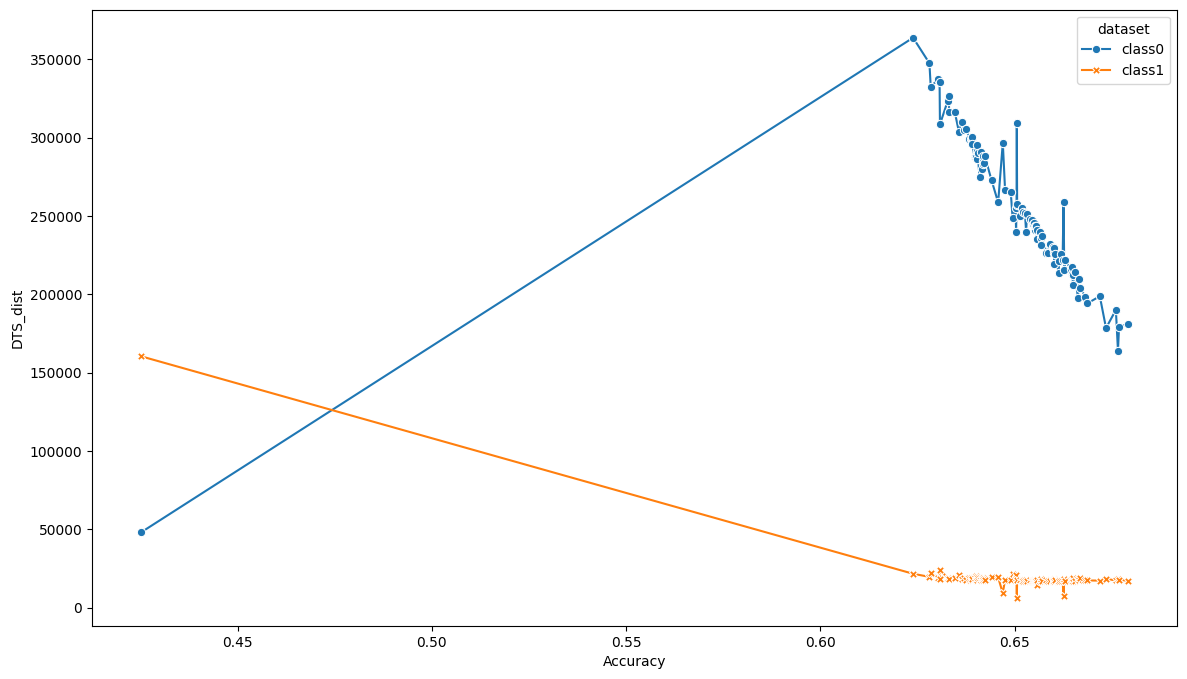

In [56]:
plt.figure(figsize=(14,8))
sns.lineplot(data=concatenated, x='Accuracy', y='DTS_dist', hue="dataset", style="dataset",
    markers=True, dashes=False)

<Axes: xlabel='Accuracy', ylabel='Kolmogorov_Smirnov_dist'>

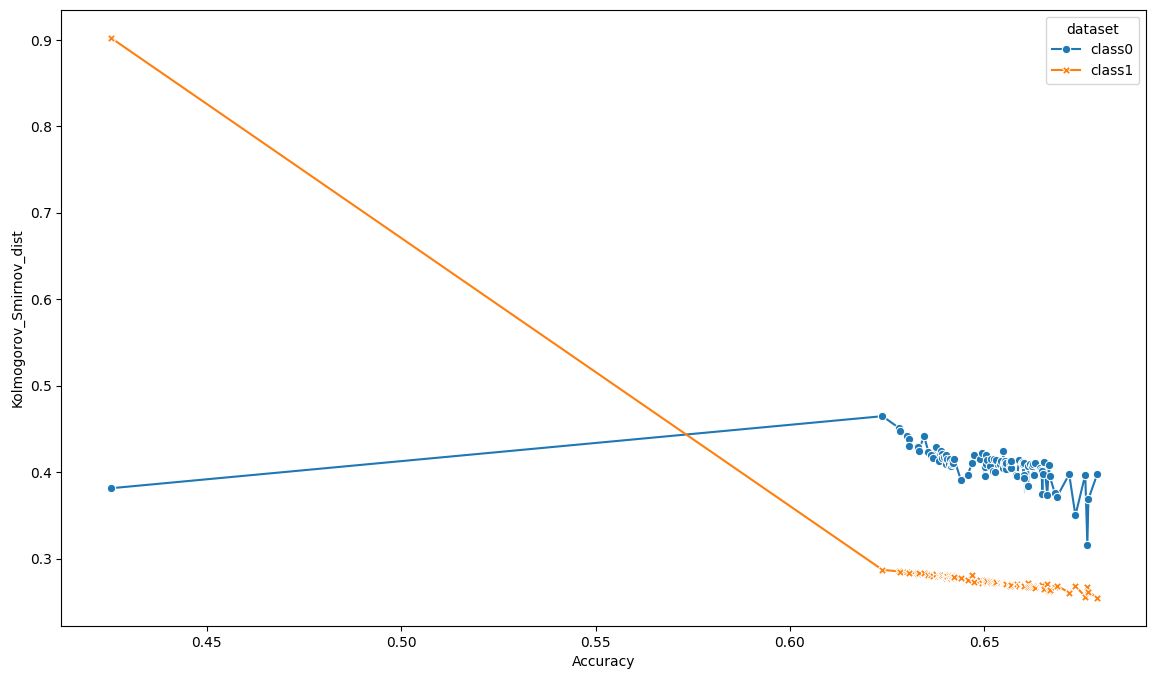

In [57]:
plt.figure(figsize=(14,8))
sns.lineplot(data=concatenated, x='Accuracy', y='Kolmogorov_Smirnov_dist', hue="dataset", style="dataset",
    markers=True, dashes=False)

<Axes: xlabel='Accuracy', ylabel='Kuiper_dist'>

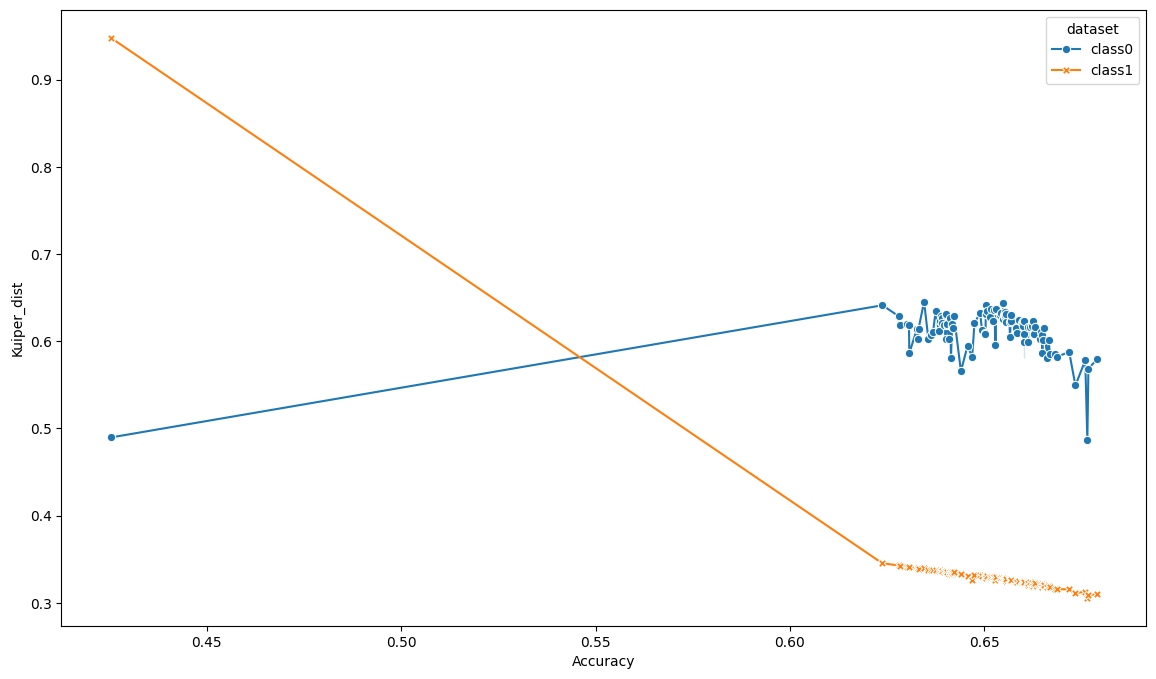

In [58]:
plt.figure(figsize=(14,8))
sns.lineplot(data=concatenated, x='Accuracy', y='Kuiper_dist', hue="dataset", style="dataset",
    markers=True, dashes=False)

<Axes: xlabel='Accuracy', ylabel='Wasserstein_dist'>

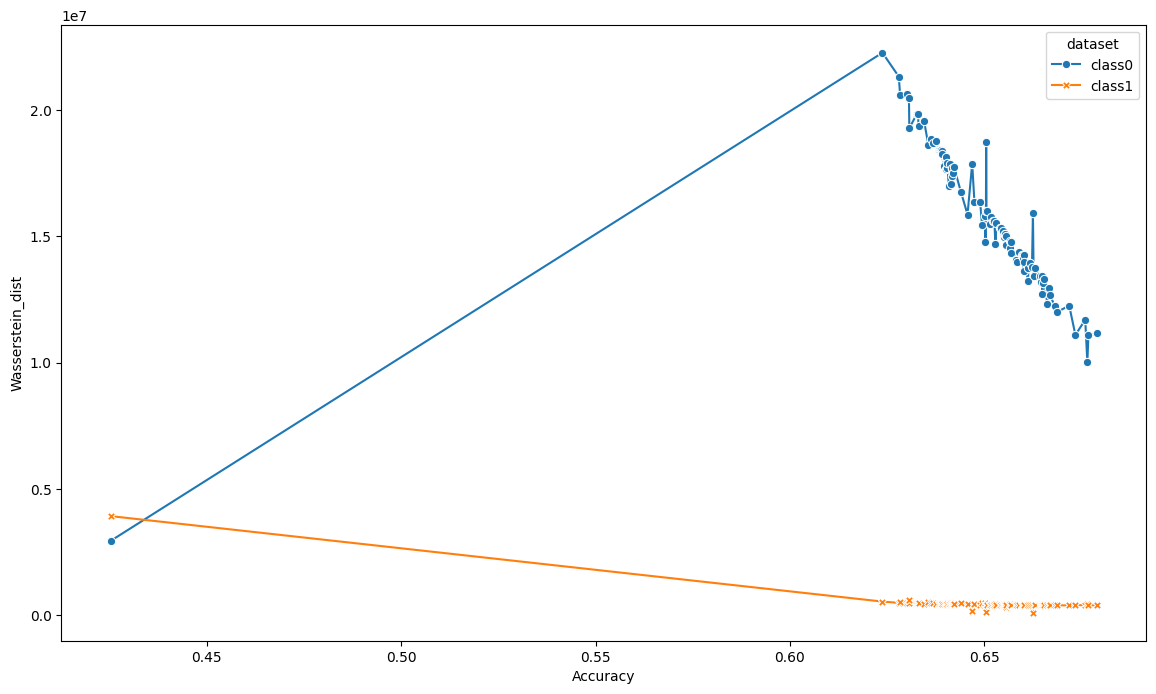

In [59]:
plt.figure(figsize=(14,8))
sns.lineplot(data=concatenated, x='Accuracy', y='Wasserstein_dist', hue="dataset", style="dataset",
    markers=True, dashes=False)

Mean Accuracy (Mu) = 64.93911790874043 %


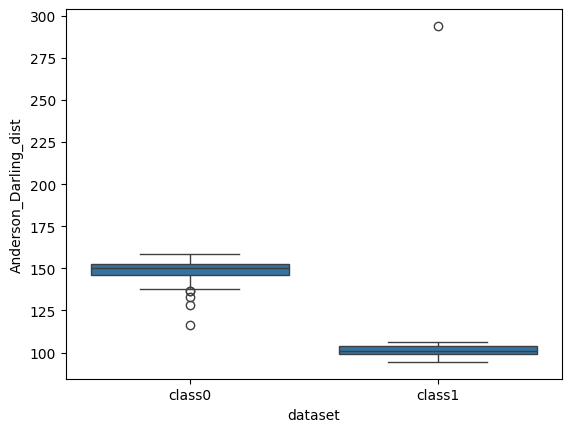

In [60]:
sns.boxplot(data=concatenated, x='dataset', y='Anderson_Darling_dist')

accuracies = concatenated['Accuracy']
mean_accuracy = accuracies[concatenated['dataset'] == 'class0'].mean()
print('Mean Accuracy (Mu) =', mean_accuracy*100, '%')

In [61]:
concatenated

,Accuracy,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist,dataset
0,0.623840,158.818934,18541.586421,363740.642145,0.464762,0.641189,2.226870e+07,class0
1,0.645734,143.963528,17102.333365,258611.275822,0.396843,0.594559,1.586175e+07,class0
2,0.632981,153.492866,18090.528820,326389.686042,0.428667,0.602675,1.982348e+07,class0
3,0.642270,152.581255,18020.059352,288423.933585,0.415324,0.628503,1.772746e+07,class0
4,0.650532,156.218233,18498.453315,309138.780675,0.408912,0.631167,1.875161e+07,class0
...,...,...,...,...,...,...,...,...
95,0.657003,100.041305,15832.273558,17163.363693,0.270034,0.326604,3.837608e+05,class1
96,0.665000,99.833157,15812.885602,17307.792468,0.270123,0.318326,3.850892e+05,class1
97,0.641836,103.982731,16643.619099,17723.145337,0.279549,0.335047,4.286903e+05,class1
98,0.656537,100.253885,15878.396671,17155.353951,0.270584,0.326717,3.877413e+05,class1


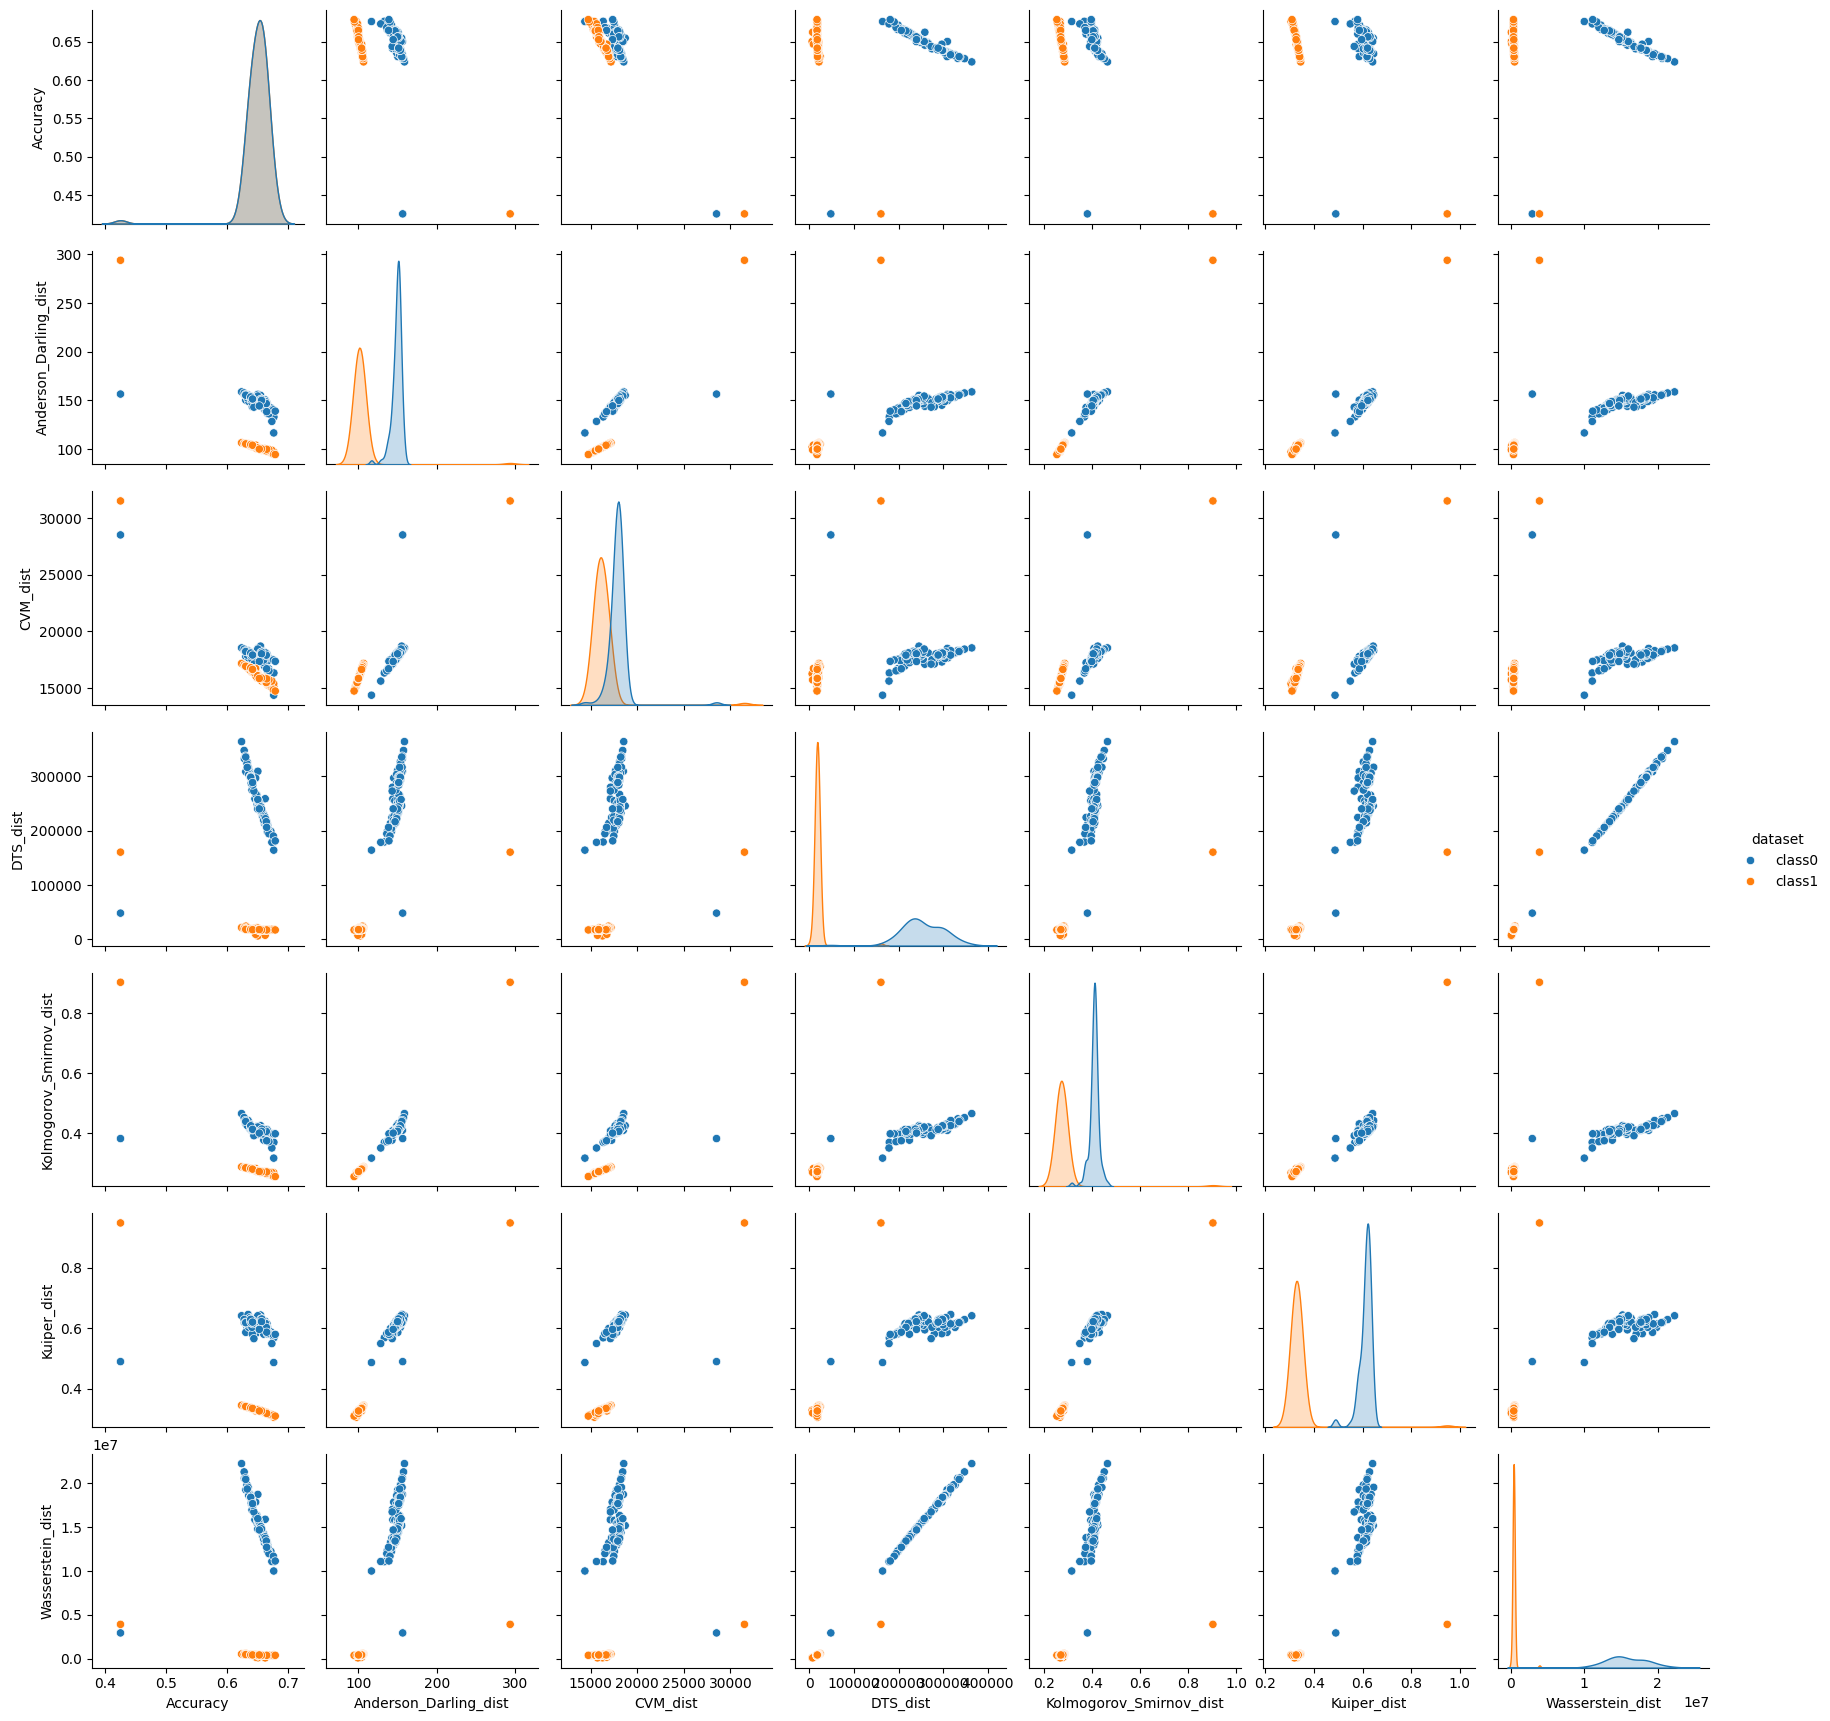

In [62]:
import seaborn as sns
sns.pairplot(concatenated, hue="dataset")